# **Chapter 10: Image segmentation**
In this notebook we demonstrate several classic **segmentation** techniques: Laplacian‑based zero‑crossing (Marr–Hildreth), gradient thresholding and Canny edges, global (Otsu) and local thresholding, and a basic watershed segmentation. The goal is to demonstrate and compare their behavior — edge thickness, noise sensitivity, and ability to outline contiguous objects — under consistent settings. We use the same *rocks* image as in the previous chapter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[10,6]

In [2]:
I = io.imread('rocks.png')

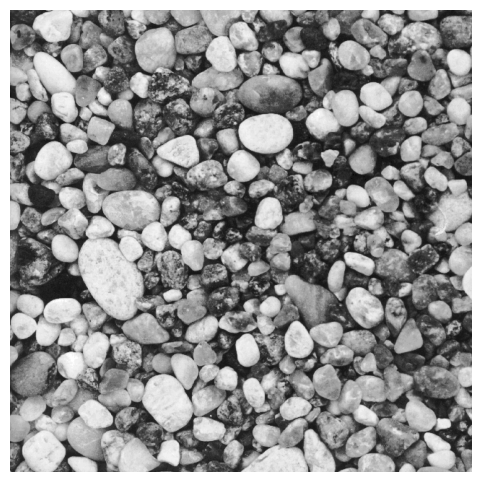

In [3]:
plt.imshow(I)
plt.axis('off');

### Point and line detection
We begin with **Laplacian filtering** to detect intensity discontinuities; the filter response takes both positive and negative values around edges. This prepares us for zero‑crossing–based edge detection.

In [4]:
from skimage.filters import laplace

L = laplace(I)

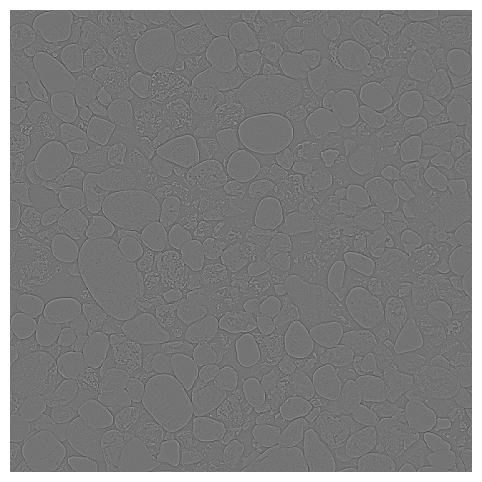

In [5]:
plt.imshow(L)
plt.axis('off');

A simple binarization is to threshold the **absolute** Laplacian response. Below we use $t=0.1\,\max |L|$, which highlights strong transitions but produces relatively **thick** edge bands.

In [6]:
t = L.max()*0.1

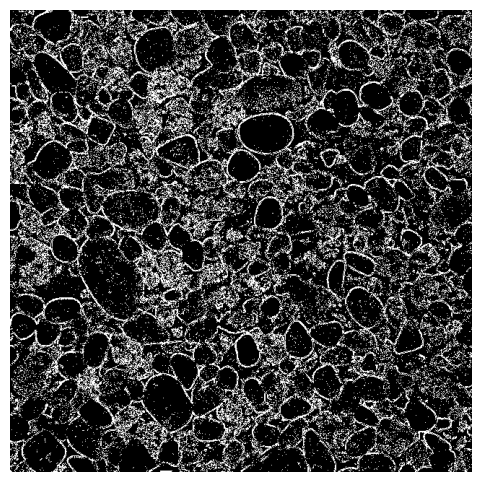

In [7]:
plt.imshow(abs(L)>t)
plt.axis('off');

To obtain **thinner** edges, we keep only **positive** Laplacian values (avoid $|\cdot|$) before thresholding. This better localizes one side of the transition at the cost of missing some edges.

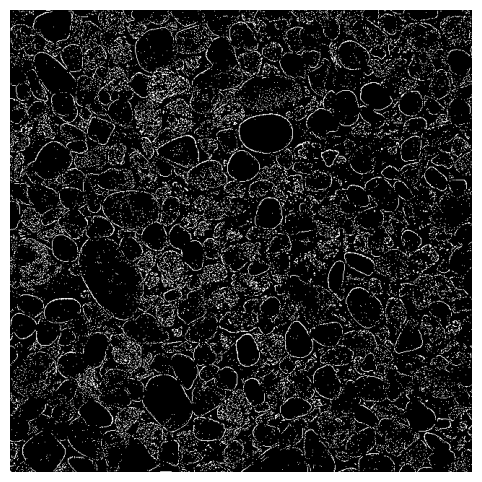

In [8]:
plt.imshow(L>t)
plt.axis('off');

### Marr-Hildreth algorithm
The Marr–Hildreth method smooths the image with a Gaussian (here $\sigma=2$) and then applies the Laplacian; edges are detected as **zero crossings** between positive and negative lobes. Smoothing suppresses noise so the resulting edge map is cleaner than raw Laplacian thresholding.

In [9]:
from skimage.filters import gaussian

F = gaussian(I,2)
L = laplace(F)

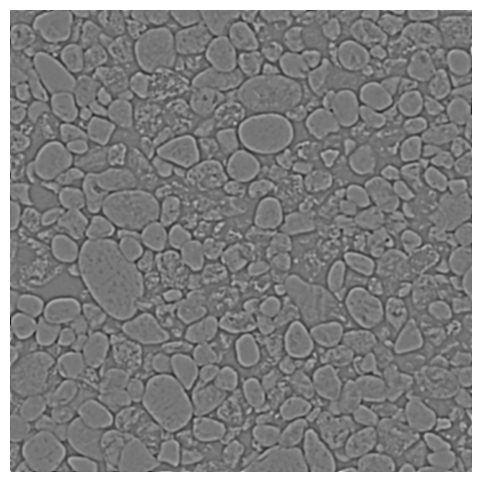

In [10]:
plt.imshow(L)
plt.axis('off');

We detect zero crossings by testing where positive and negative regions (after small dilation) meet. The intersection marks likely edge locations; the result is less noisy than simple thresholding.

In [11]:
from skimage.morphology import binary_dilation, disk

def zero_crossings(L):
    S = disk(1)
    t = L.max()*0.05
    P = binary_dilation(L>t,S)
    N = binary_dilation(L<-t,S)
    return np.bitwise_and(P,N)

In [12]:
MH = zero_crossings(L)

The output indeed contains fewer spurious responses than the absolute‑value thresholding used earlier.

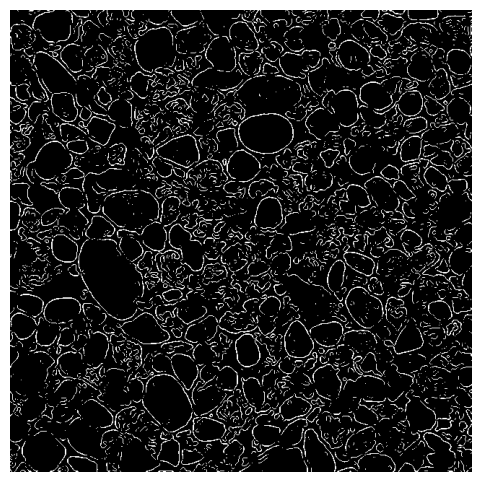

In [13]:
plt.imshow(MH)
plt.axis('off');

### Gradient thresholding
An alternative is to compute Sobel gradients $g_x,g_y$ and the **magnitude** $G=\sqrt{g_x^2+g_y^2}$. We then threshold at a fraction of $\max G$; this emphasizes strong edges but, with a single global threshold, weak edges are often missed and strong edges remain thick.

In [14]:
from skimage.filters import sobel_h, sobel_v

gx = sobel_h(I)
gy = sobel_v(I)

In [15]:
G = np.sqrt(gx**2+gy**2)

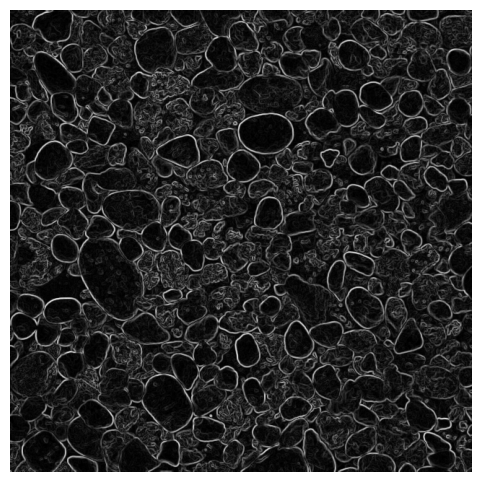

In [16]:
plt.imshow(G)
plt.axis('off');

With $t=0.3\,\max G$ we obtain a map where many edges are **thick** and some fine boundaries are missing, illustrating the limitations of global magnitude thresholding.

In [17]:
t = G.max()*0.3

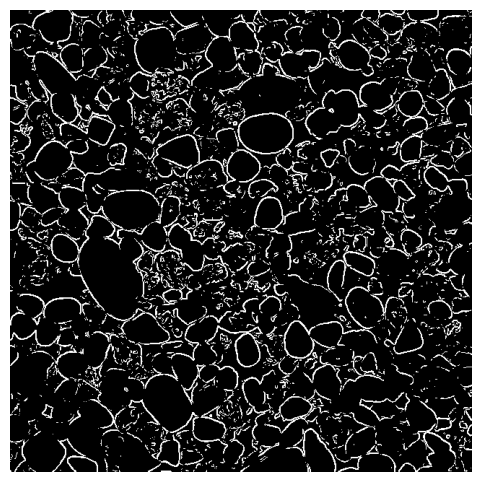

In [18]:
plt.imshow(G>t)
plt.axis('off');

### Canny edge detection
**Canny** addresses these issues via Gaussian smoothing, non‑maximum suppression (to thin edges), and hysteresis with two thresholds to keep weak edges connected to strong ones. The result shows thin, well‑localized contours with fewer false detections than previous methods.

In [19]:
from skimage.feature import canny

C = canny(I,2)

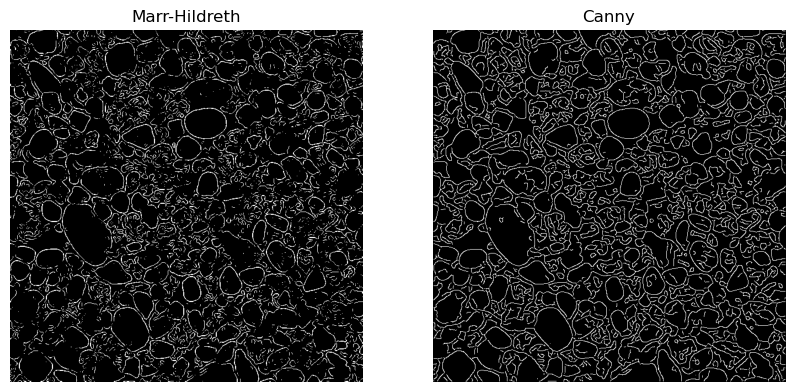

In [20]:
plt.subplot(1,2,1)
plt.imshow(MH)
plt.title('Marr-Hildreth')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(C)
plt.title('Canny')
plt.axis('off');

### Otsu's method
For **region‑based segmentation**, **Otsu’s threshold** chooses a global gray‑level threshold that maximizes inter‑class variance. Using `threshold_otsu`, we obtain a single value that separates foreground and background reasonably well for bimodal histograms.

In [21]:
from skimage.filters import threshold_otsu

t = threshold_otsu(I)

In [22]:
print(t)

128


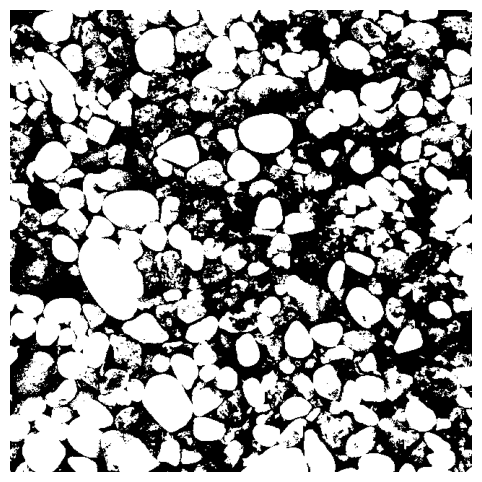

In [23]:
plt.imshow(I>t)
plt.axis('off');

### Local thresholding
When illumination varies, we compute a **local threshold** per pixel using statistics over a $21\times21$ window. The resulting mask adapts to slow background changes and, on this image, provides a solid segmentation of the stones.

In [24]:
from skimage.filters import threshold_local

T = threshold_local(I, block_size=21)

In [25]:
print(T.shape)

(640, 640)


In [26]:
S = I>T

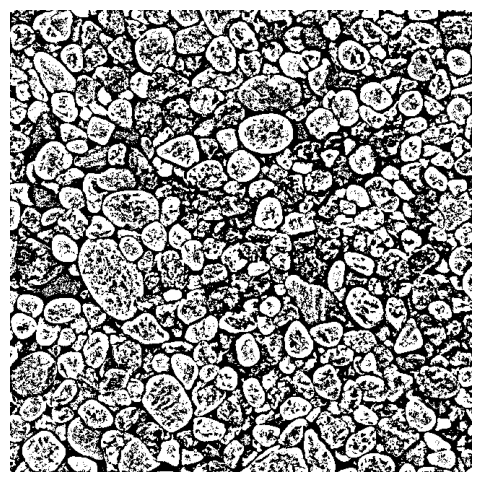

In [27]:
plt.imshow(S)
plt.axis('off');

### Watershed segmentation
**Watershed** uses a topographic view of a gradient (or intensity) image to grow basins from **markers** until they meet at ridges (object boundaries). Here we build markers from eroded regions and their complement and run `watershed` on the gradient; the final boundaries are overlaid on the labeled result.

In [28]:
from skimage.morphology import binary_erosion, dilation, erosion, label
from skimage.segmentation import watershed


In [29]:
L = label(S, connectivity=1)

In [30]:
B = I<50

In [31]:
mask = binary_erosion(S,disk(3))

In [32]:
markers = L*mask-B*(1-mask)

In [ ]:
W = watershed(G,markers)

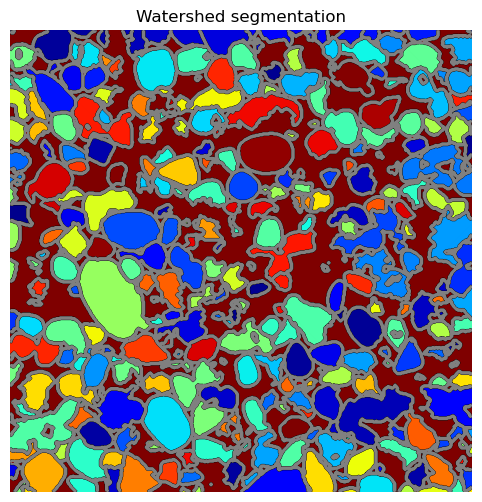

In [34]:
plt.imshow(W.astype('uint8'),cmap='jet')
plt.contour((dilation(W)-erosion(W))>0,1)
plt.title('Watershed segmentation')
plt.axis('off');